In [588]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from thermography_dataset import ThermDataset
%matplotlib inline

## Parameters 
Spec to Temp
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

Temp to Spec
Loss: 0.0233

# Prepare Data

In [589]:
direction = 1
noise = 0.001

In [590]:
dataset = ThermDataset(fp='combined_data.xlsx', noise_scale=noise, tandem=1, direction=direction)

In [591]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [592]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

# Design Model 
(input size, output size, forward pass)

In [593]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin4 = nn.Linear(30, 30)
        self.lin5 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, X_batch):
        output = F.leaky_relu(self.lin1(X_batch))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = F.leaky_relu(self.lin4(output))
        output = F.leaky_relu(self.lin5(output))
        output = self.lin_fin(output)
        return output

In [594]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, y_batch):
        output = F.leaky_relu(self.lin1(y_batch))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = F.leaky_relu(self.lin4(output))
        output = F.leaky_relu(self.lin5(output))
        output = self.lin_fin(output)
        return output

In [595]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, y):
        pred_temp = self.inverse_model(y)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [596]:
n_samples = len(train_dataset)
_, middle_size = dataset.x.shape
_, io_size = dataset.y.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)

# Construct Loss and Optimizer

In [597]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer_forward_A = torch.optim.Adam(forward_model.parameters(), lr=learning_rate)
optimizer_forward_B = torch.optim.Rprop(forward_model.parameters(), lr=learning_rate)
optimizer_tandem_A = torch.optim.Adam(inverse_model.parameters(), lr=learning_rate)
optimizer_tandem_B = torch.optim.Rprop(inverse_model.parameters(), lr=learning_rate)

# Training Loop

In [598]:
def train_forward_model(forward_model, train_loader):

    forward_loss_list = []
    num_forward_epochs = 100
    best_forward_loss = np.inf
    best_forward_epoch = 0

    # use optimizer A for first __% of training, then optimizer B
    percent_optim_A = 0

    for epoch in range(num_forward_epochs):
        for X_batch, y_batch in train_loader:
            # forward pass and loss
            y_pred = forward_model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            loss.backward()

            # use optimizer A
            if epoch < (num_forward_epochs * percent_optim_A):
                # update
                optimizer_forward_A.step()

                # empty gradients
                optimizer_forward_A.zero_grad()

            # use optimizer B
            else:
                 # update
                optimizer_forward_B.step()

                # empty gradients
                optimizer_forward_B.zero_grad()
        
        forward_loss_list.append(loss.item())
        
        if loss < best_forward_loss:
            best_forward_loss = loss
            best_forward_epoch = epoch+1

        if (epoch+1) % int(num_forward_epochs/10) == 0:
            print(f'forward epoch: {epoch+1}, forward loss = {loss}')

    print(f'\nbest forward loss: {best_forward_loss:.4f} in forward epoch: {best_forward_epoch}\n')
    return num_forward_epochs, forward_loss_list

In [599]:
def train_tandem_model(inverse_model, forward_model, train_loader):

    tandem_loss_list = []
    inverse_loss_list = []
    num_inverse_epochs = 100
    best_inverse_loss = np.inf
    best_inverse_epoch = 0


    # use optimizer A for first __ percentage of training, then optimizer B
    percent_optim_A = 0

    # trains the inverse model first, then the tandem; specifies the percentage of inverse training
    percent_inverse = 1


    # using sum loss
    sum = False
    # in sum_loss, inverse and tandem losses are weighed differently; specifies the percentage of inverse weight
    inverse_weight = .65

    for epoch in range(num_inverse_epochs):
        # indicate what type of training is done
        if epoch % (num_inverse_epochs / 10) == 0:
            if epoch < (num_inverse_epochs * percent_inverse):
                print('inverse training')
            else:
                print('tandem training')

        for X_batch, y_batch in train_loader:
            # forward pass through both models
            X_pred = inverse_model(y_batch)
            y_pred = forward_model(X_pred)

            # calculate tandem loss (used for training)
            tandem_loss = criterion(y_pred, y_batch)

            # calculate the inverse loss (what we care about but not used for training)
            inverse_loss = criterion(X_pred, X_batch)

            # sum of the losses
            sum_loss = (inverse_weight * inverse_loss) + ((1 - inverse_weight) * tandem_loss)

            if sum:
                sum_loss.backward()
            
            else:
                # for first half of epochs, train inverse network
                if epoch < (num_inverse_epochs * percent_inverse):
                    inverse_loss.backward()

                # for second half of epochs, train tandem network
                else:
                    tandem_loss.backward()

            # use optimizer A
            if epoch < (num_inverse_epochs * percent_optim_A):
                # update
                optimizer_tandem_A.step()

                # empty gradients
                optimizer_tandem_A.zero_grad()

                print('optim A')

            # use optimizer B
            else:
                 # update
                optimizer_tandem_B.step()

                # empty gradients
                optimizer_tandem_B.zero_grad()
        
        tandem_loss_list.append(tandem_loss.item())
        inverse_loss_list.append(inverse_loss.item())
        
        if inverse_loss < best_inverse_loss:
            best_inverse_loss = inverse_loss
            best_inverse_epoch = epoch+1

        if (epoch+1) % int(num_inverse_epochs/10) == 0:
            print(f'tandem epoch: {epoch+1}, tandem loss = {tandem_loss:.4f}, *INVERSE LOSS* = {inverse_loss:.4f}')

    print(f'\n best inverse loss: {best_inverse_loss:.4f} in inverse epoch: {best_inverse_epoch}')
    return num_inverse_epochs, inverse_loss_list, tandem_loss_list

In [600]:
# first train the forward model
num_forward_epochs, forward_loss_list = train_forward_model(forward_model, train_loader)

# freeze forward layers
for param in forward_model.lin1.parameters():
    param.requires_grad = False

for param in forward_model.lin2.parameters():
    param.requires_grad = False

for param in forward_model.lin3.parameters():
    param.requires_grad = False

for param in forward_model.lin4.parameters():
    param.requires_grad = False

for param in forward_model.lin5.parameters():
    param.requires_grad = False

for param in forward_model.lin_fin.parameters():
    param.requires_grad = False

# train the tandem model
num_inverse_epochs, inverse_loss_list, tandem_loss_list = train_tandem_model(inverse_model, forward_model, train_loader)

forward epoch: 10, forward loss = 0.0006145957158878446
forward epoch: 20, forward loss = 0.002134479582309723
forward epoch: 30, forward loss = 0.0010238154791295528
forward epoch: 40, forward loss = 0.002361655468121171
forward epoch: 50, forward loss = 0.0006942036561667919
forward epoch: 60, forward loss = 0.0008037733496166766
forward epoch: 70, forward loss = 0.0010268224868923426
forward epoch: 80, forward loss = 0.0006973334820941091
forward epoch: 90, forward loss = 0.000659156939946115
forward epoch: 100, forward loss = 0.0007534988690167665

best forward loss: 0.0002 in forward epoch: 59

inverse training
tandem epoch: 10, tandem loss = 0.0084, *INVERSE LOSS* = 375.2249
inverse training
tandem epoch: 20, tandem loss = 0.0095, *INVERSE LOSS* = 268.2834
inverse training
tandem epoch: 30, tandem loss = 0.0067, *INVERSE LOSS* = 270.9304
inverse training
tandem epoch: 40, tandem loss = 0.0096, *INVERSE LOSS* = 264.3596
inverse training
tandem epoch: 50, tandem loss = 0.0079, *INV

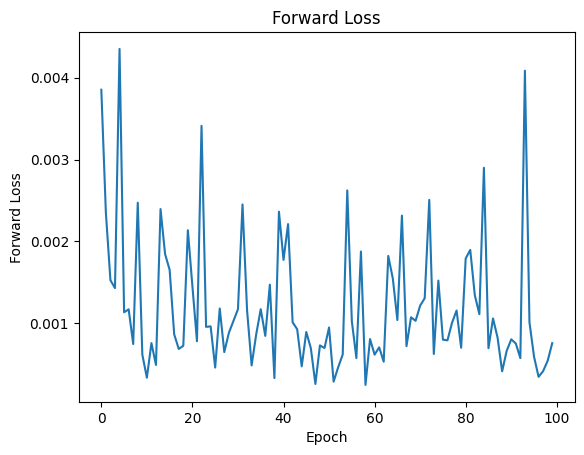

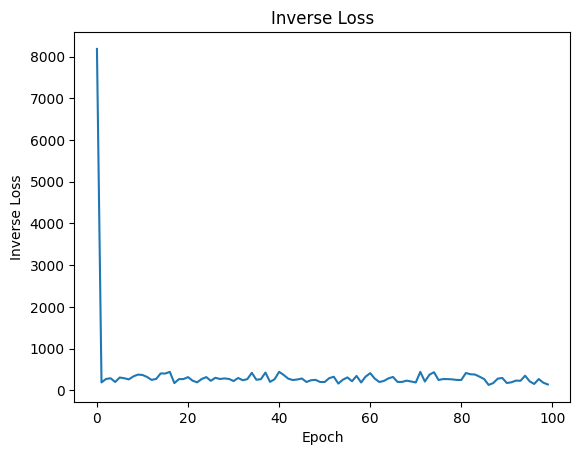

In [601]:
# plot forward loss
plt.plot(forward_loss_list)

plt.title("Forward Loss")
plt.xlabel("Epoch")
plt.ylabel("Forward Loss")
plt.show()

# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()



# Testing

In [602]:
import matplotlib.pyplot as plt

# to graph temperature error, set graph_temp to True
# to graph spectra error, set graph_temp to False
graph_temp = True

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, label='predicted')

    if graph_temp:
        plt.title("Temperature Distribution")
        plt.xlabel("Silica Layer")
        plt.ylabel("Temperature (K)")
    else:
        plt.title("Radiation Spectrum")
        plt.xlabel("Wavelength Index")
        plt.ylabel("Intensity")

    plt.legend()
    plt.show()

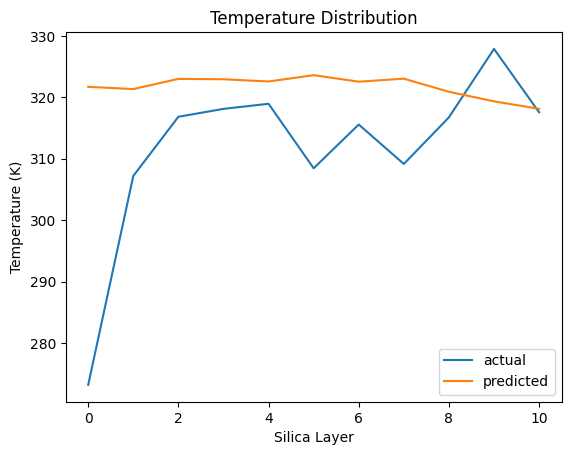

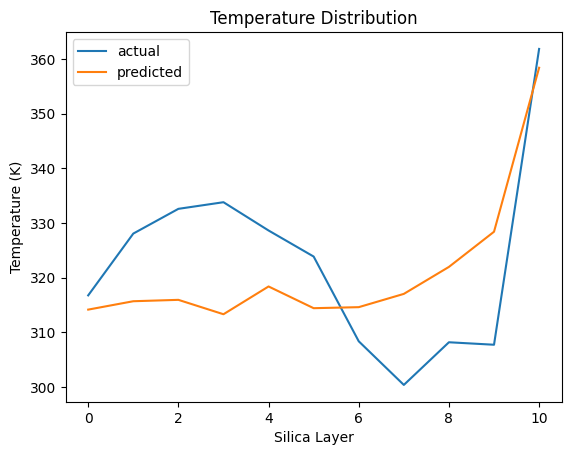

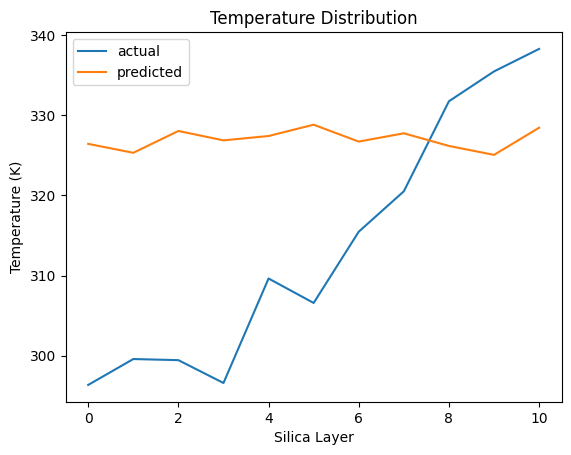

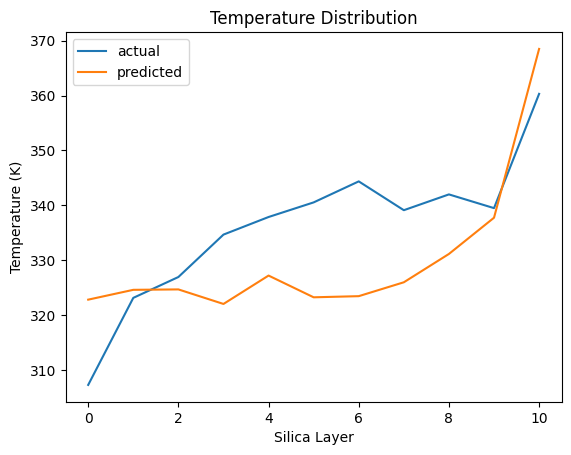

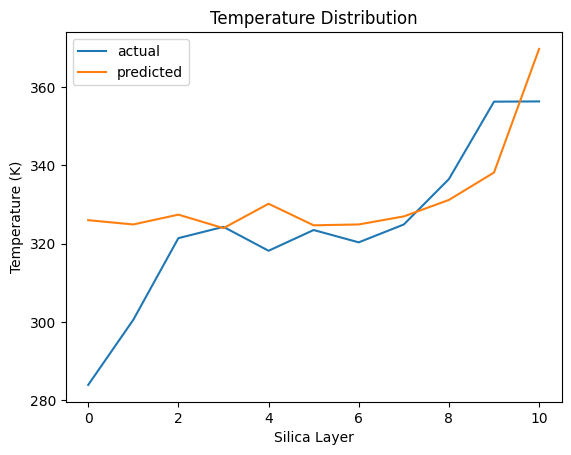

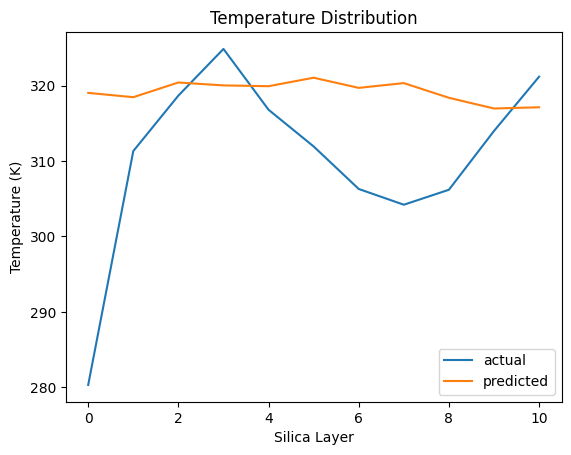

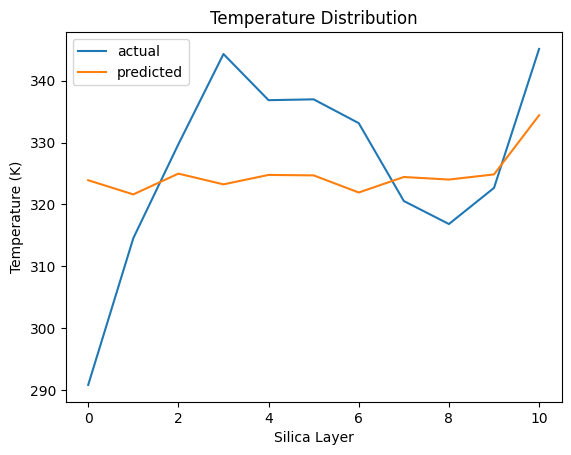

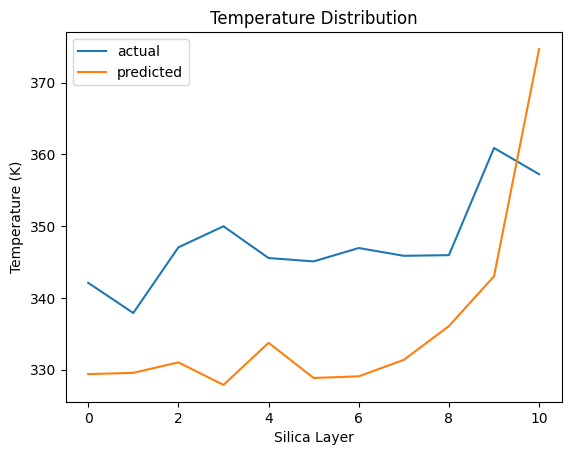

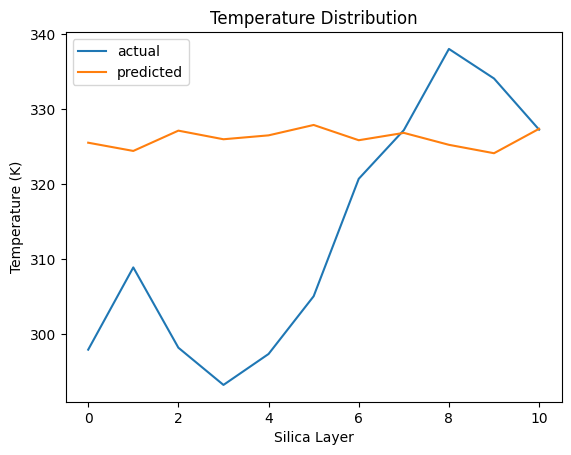

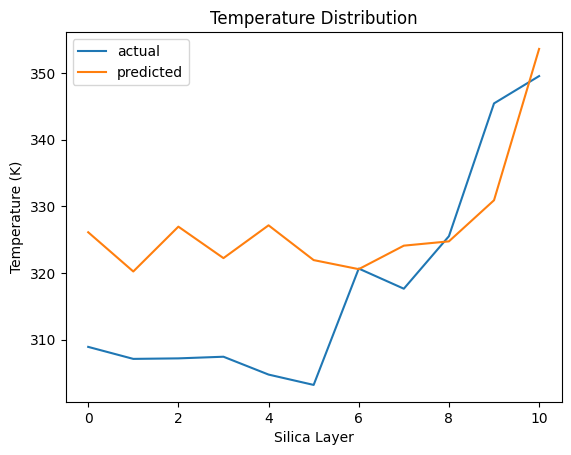

In [603]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        actual_input = y_batch
        actual_middle = X_batch

        pred_middle = inverse_model(actual_input)
        inverse_test_loss = criterion(pred_middle, actual_middle)

        pred_output = forward_model(pred_middle)
        
        total_loss += inverse_test_loss.item() * len(X_batch)
        n_samples += len(X_batch)
        current_batch += 1
        
        if graph_temp:
            if current_batch % int(total_batches/10) == 0:
                plot_actual_vs_pred(pred_middle.numpy(), actual_middle.numpy(), 0) 
        else:
            if current_batch % int(total_batches/10) == 0:
                plot_actual_vs_pred(pred_output.numpy(), actual_input.numpy(), 0) 

# average_loss = total_loss/n_samples
# print(f"average loss: {average_loss}")